# Time Series of Phytoplankton Bloom Timing and Environmental Drivers from 2015-2019 at Station S3 (201812 model run)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, places, viz_tools, visualisations
import xarray as xr
import pandas as pd
import pickle
import os
import bloomdrivers

%matplotlib inline

In [24]:
start=dt.datetime(2019,1,1)
end=dt.datetime(2019,3,31)
dateslist=[[dt.datetime(2019,1,1),dt.datetime(2019,1,31)],
           [dt.datetime(2019,1,31),dt.datetime(2019,2,28)],
           [dt.datetime(2019,2,28),dt.datetime(2019,3,31)]]
year=str(dateslist[0][0].year)
forbloomstart=dt.datetime(2019,2,15)
forbloomend=dt.datetime(2019,6,15)
modver='201812'
loc='S3'

savedir='/ocean/aisabell/MEOPAR/extracted_files'

fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
fname2=f'JanToMarch_TimeSeries_{year}_{modver}.pkl' # for non-location specific variables
fname3=f'springBloomTime_{year}_{loc}_{modver}.pkl'
savepath=os.path.join(savedir,fname)
savepath2=os.path.join(savedir,fname2)
savepath3=os.path.join(savedir,fname3)
recalc=False

1.1363636363636362

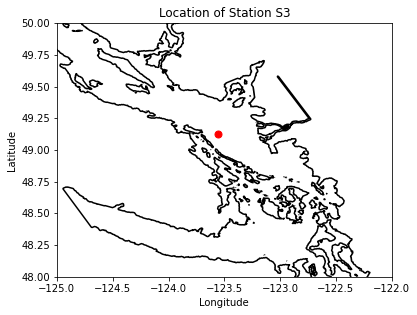

In [25]:
loc='S3'

# lat and lon informatin for place:
lon,lat=places.PLACES['S3']['lon lat']
# get place information on SalishSeaCast grid:
ij,ii=places.PLACES['S3']['NEMO grid ji']
# GEM2.5 grid ji is atm forcing grid for ops files
jw,iw=places.PLACES['S3']['GEM2.5 grid ji']

fig, ax = plt.subplots(1,1,figsize = (6,6))
with xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc') as mesh:
    ax.contour(mesh.nav_lon,mesh.nav_lat,mesh.tmask.isel(t=0,z=0),[0.1,],colors='k')
    tmask=np.array(mesh.tmask)
    gdept_1d=np.array(mesh.gdept_1d)
    e3t_0=np.array(mesh.e3t_0)
ax.plot(lon, lat, '.', markersize=14, color='red')
ax.set_ylim(48,50)
ax.set_xlim(-125,-122)
ax.set_title('Location of Station S3')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
viz_tools.set_aspect(ax,coords='map')

### location specific variables for environmental driver analysis

In [26]:

if recalc==True or not os.path.isfile(savepath):
    basedir='/results/SalishSea/nowcast-green.201812/'
    nam_fmt='nowcast'
    flen=1 # files contain 1 day of data each
    ftype= 'ptrc_T' # load bio files
    tres=24 # 1: hourly resolution; 24: daily resolution  
    bio_time=list()
    diat_alld=list()
    no3_alld=list()
    flag_alld=list()
    cili_alld=list()
    microzoo_alld=list()
    mesozoo_alld=list()
    intdiat=list()
    intphyto=list()
    spar=list()
    intmesoz=list()
    intmicroz=list()
    grid_time=list()
    temp=list()
    salinity=list()
    u_wind=list()
    v_wind=list()
    twind=list()
    solar=list()
    ik=0
    for ind, datepair in enumerate(dateslist):
        start=datepair[0]
        end=datepair[1]
        flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
        flist3 = et.index_model_files(start,end,basedir,nam_fmt,flen,"grid_T",tres)
        fliste3t = et.index_model_files(start,end,basedir,nam_fmt,flen,"carp_T",tres)
        with xr.open_mfdataset(flist['paths']) as bio:
            bio_time.append(np.array(bio.time_centered[:]))
            no3_alld.append(np.array(bio.nitrate.isel(y=ij,x=ii)) )
            diat_alld.append(np.array(bio.diatoms.isel(y=ij,x=ii)))
            flag_alld.append(np.array(bio.flagellates.isel(y=ij,x=ii)))
            cili_alld.append(np.array(bio.ciliates.isel(y=ij,x=ii)))
            microzoo_alld.append(np.array(bio.microzooplankton.isel(y=ij,x=ii)))
            mesozoo_alld.append(np.array(bio.mesozooplankton.isel(y=ij,x=ii)))

            with xr.open_mfdataset(fliste3t['paths']) as carp:
                intdiat.append(np.array(np.sum(bio.diatoms.isel(y=ij,x=ii)*carp.e3t.isel(y=ij,x=ii),1))) # depth integrated diatom
                intphyto.append(np.array(np.sum((bio.diatoms.isel(y=ij,x=ii)+bio.flagellates.isel(y=ij,x=ii)\
                                +bio.ciliates.isel(y=ij,x=ii))*carp.e3t.isel(y=ij,x=ii),1)))
                spar.append(np.array(carp.PAR.isel(deptht=ik,y=ij,x=ii)))
                intmesoz.append(np.array(np.sum(bio.mesozooplankton.isel(y=ij,x=ii)*carp.e3t.isel(y=ij,x=ii),1)))
                intmicroz.append(np.array(np.sum(bio.microzooplankton.isel(y=ij,x=ii)*carp.e3t.isel(y=ij,x=ii),1)))

        with xr.open_mfdataset(flist3['paths']) as grid:
            grid_time.append(np.array(grid.time_centered[:]))
            temp.append(np.array(grid.votemper.isel(deptht=ik,y=ij,x=ii)) )#surface temperature
            salinity.append(np.array(grid.vosaline.isel(deptht=ik,y=ij,x=ii))) #surface salinity

        opsdir='/results/forcing/atmospheric/GEM2.5/operational'

        flist2=et.index_model_files(start,end,opsdir,nam_fmt='ops',flen=1,ftype='None',tres=24)
        with xr.open_mfdataset(flist2['paths']) as winds:
            u_wind.append(np.array(winds.u_wind.isel(y=jw,x=iw)))
            v_wind.append(np.array(winds.v_wind.isel(y=jw,x=iw)))
            twind.append(np.array(winds.time_counter))
            solar.append(np.array(winds.solar.isel(y=jw,x=iw)))
    
    bio_time=np.concatenate(bio_time,axis=0)
    diat_alld=np.concatenate(diat_alld,axis=0)
    no3_alld=np.concatenate(no3_alld,axis=0)
    flag_alld=np.concatenate(flag_alld,axis=0)
    cili_alld=np.concatenate(cili_alld,axis=0)
    microzoo_alld=np.concatenate(microzoo_alld,axis=0)
    mesozoo_alld=np.concatenate(mesozoo_alld,axis=0)
    intdiat=np.concatenate(intdiat,axis=0)
    intphyto=np.concatenate(intphyto,axis=0)
    spar=np.concatenate(spar,axis=0)
    intmesoz=np.concatenate(intmesoz,axis=0)
    intmicroz=np.concatenate(intmicroz,axis=0)
    grid_time=np.concatenate(grid_time,axis=0)
    temp=np.concatenate(temp,axis=0)
    salinity=np.concatenate(salinity,axis=0)
    u_wind=np.concatenate(u_wind,axis=0)
    v_wind=np.concatenate(v_wind,axis=0)
    twind=np.concatenate(twind,axis=0)
    solar=np.concatenate(solar,axis=0)
    
    ### calculations based on saved values
    no3_30to90m=np.sum(no3_alld[:,22:26]*e3t_0[:,22:26,ij,ii],1)/np.sum(e3t_0[:,22:26,ij,ii]) # average, considering cell thickness
    sno3=no3_alld[:,0]
    sdiat=diat_alld[:,0]
    sflag=flag_alld[:,0]
    scili=cili_alld[:,0]
    intzoop=intmesoz+intmicroz
    fracdiat=intdiat/intphyto # depth integrated fraction of diatoms
    zoop_alld=microzoo_alld+mesozoo_alld
    sphyto=sdiat+sflag+scili
    phyto_alld=diat_alld+flag_alld+cili_alld
    percdiat=sdiat/sphyto # fraction surface diatoms

    # wind speed:
    wspeed=np.sqrt(u_wind**2 + v_wind**2)
    # wind direction in degrees from east
    d = np.arctan2(v_wind, u_wind)
    winddirec=np.rad2deg(d + (d < 0)*2*np.pi)
    
    allvars=(bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,
              intdiat,intphyto,spar,intmesoz,intmicroz,
            grid_time,temp,salinity,u_wind,v_wind,twind,solar,
            no3_30to90m,sno3,sdiat,sflag,scili,intzoop,fracdiat,zoop_alld,sphyto,phyto_alld,percdiat,
            wspeed,winddirec)
    pickle.dump(allvars,open(savepath,'wb'))
else:
    pvars=pickle.load(open(savepath,'rb'))
    (bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,
              intdiat,intphyto,spar,intmesoz,intmicroz,
            grid_time,temp,salinity,u_wind,v_wind,twind,solar,
            no3_30to90m,sno3,sdiat,sflag,scili,intzoop,fracdiat,zoop_alld,sphyto,phyto_alld,percdiat,
            wspeed,winddirec)=pvars

### loops that are not location specific (do not need to be redone for each location):

In [27]:

k250=32 # approximate index for 250 m
if recalc==True or not os.path.isfile(savepath2):

    basedir='/results/SalishSea/nowcast-green.201812/'
    nam_fmt='nowcast'
    flen=1 # files contain 1 day of data each
    ftype= 'ptrc_T' # load bio files
    tres=24 # 1: hourly resolution; 24: daily resolution  
    flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
    flist3 = et.index_model_files(start,end,basedir,nam_fmt,flen,"grid_T",tres)
    fliste3t = et.index_model_files(start,end,basedir,nam_fmt,flen,"carp_T",tres)

    ik=0
    with xr.open_mfdataset(flist['paths']) as bio:
        no3_past250m=np.array(np.sum(np.sum(np.sum(bio.nitrate.isel(deptht=slice(32,40))*sogmask[:,32:,:,:]*e3t_0[:,32:,:,:],3),2),1)\
                /np.sum(sogmask[0,32:,:,:]*e3t_0[0,32:,:,:]))
        
    # reading Fraser river flow files
    dfFra=pd.read_csv('/ocean/eolson/MEOPAR/obs/ECRivers/Flow/FraserHopeDaily__Feb-8-2021_06_29_29AM.csv',
                      skiprows=1)
    # the original file contains both flow and water level information in the same field (Value)
    # keep only the flow data, where PARAM=1 (drop PARAM=2 values, water level data)
    # flow units are m3/s
    # DD is YD, year day (ie. 1 is jan 1)
    dfFra.drop(dfFra.loc[dfFra.PARAM==2].index,inplace=True)  

    # rename 'Value' column to 'Flow' now that we have removed all the water level rows
    dfFra.rename(columns={'Value':'Flow'}, inplace=True) 
        # inplace=True does this function on the orginal dataframe

    # no time information so use dt.date
    dfFra['Date']=[dt.date(iyr,1,1)+dt.timedelta(days=idd-1) for iyr, idd in zip(dfFra['YEAR'],dfFra['DD'])]
    # taking the value from the yr column, jan1st date, and making jan1 column to be 1 not 0
    dfFra.head(2)

    # select portion of dataframe in desired date range
    dfFra2=dfFra.loc[(dfFra.Date>=start.date())&(dfFra.Date<=end.date())]
    riv_time=dfFra2['Date'].values
    rivFlow=dfFra2['Flow'].values
    # could also write dfFra['Date'], sometimes this is required
    # newstart is a datetime object, so we convert it to just a date with .date
    
    allvars=(no3_past250m,riv_time,rivFlow)
    pickle.dump(allvars,open(savepath2,'wb'))
else:
    pvars=pickle.load(open(savepath2,'rb'))
    (no3_past250m,riv_time,rivFlow)=pvars

### Variables for bloom timing calculations

In [28]:
if recalc==True or not os.path.isfile(savepath3):
    basedir='/results/SalishSea/nowcast-green.201812/'
    nam_fmt='nowcast'
    flen=1 # files contain 1 day of data each
    ftype= 'ptrc_T' # load bio files
    tres=24 # 1: hourly resolution; 24: daily resolution  
    flist=et.index_model_files(forbloomstart,forbloomend,basedir,nam_fmt,flen,ftype,tres)
    flist2=et.index_model_files(forbloomstart,forbloomend,basedir,nam_fmt,flen,"carp_T",tres)

    ik=0
    with xr.open_mfdataset(flist['paths']) as bio:
        bio_time0=np.array(bio.time_centered[:])
        sno30=np.array(bio.nitrate.isel(deptht=ik,y=ij,x=ii))
        sdiat0=np.array(bio.diatoms.isel(deptht=ik,y=ij,x=ii))
        sflag0=np.array(bio.flagellates.isel(deptht=ik,y=ij,x=ii))
        scili0=np.array(bio.ciliates.isel(deptht=ik,y=ij,x=ii))
        no3_alld0=np.array(bio.nitrate.isel(y=ij,x=ii)) 
        diat_alld0=np.array(bio.diatoms.isel(y=ij,x=ii))
        flag_alld0=np.array(bio.flagellates.isel(y=ij,x=ii))
        cili_alld0=np.array(bio.ciliates.isel(y=ij,x=ii))
        with xr.open_mfdataset(flist2['paths']) as carp:
            intdiat0=np.array(np.sum(bio.diatoms.isel(y=ij,x=ii)*carp.e3t.isel(y=ij,x=ii),1)) # depth integrated diatom
            intphyto0=np.array(np.sum((bio.diatoms.isel(y=ij,x=ii)+bio.flagellates.isel(y=ij,x=ii)\
                            +bio.ciliates.isel(y=ij,x=ii))*carp.e3t.isel(y=ij,x=ii),1))
    fracdiat0=intdiat0/intphyto0 # depth integrated fraction of diatoms

    sphyto0=sdiat0+sflag0+scili0
    phyto_alld0=diat_alld0+flag_alld0+cili_alld0
    percdiat0=sdiat0/sphyto0 # percent diatoms

    pickle.dump((bio_time0,sno30,sdiat0,sflag0,scili0,diat_alld0,no3_alld0,flag_alld0,cili_alld0,phyto_alld0,\
                 intdiat0,intphyto0,fracdiat0,sphyto0,percdiat0),open(savepath3,'wb'))
else:
    bio_time0,sno30,sdiat0,sflag0,scili0,diat_alld0,no3_alld0,flag_alld0,cili_alld0,phyto_alld0,\
                 intdiat0,intphyto0,fracdiat0,sphyto0,percdiat0=pickle.load(open(savepath3,'rb'))

###  *** Stop and check, have you made pickle files for all the years? ***

In [29]:
# loop through years of spring time series (mid feb-june) for bloom timing
years=list()
bloomtime1=list()
bloomtime2=list()
bloomtime3=list()
for year in range(2015,2020):
    fname3=f'springBloomTime_{str(year)}_{loc}_{modver}.pkl'
    savepath3=os.path.join(savedir,fname3)
    bio_time0,sno30,sdiat0,sflag0,scili0,diat_alld0,no3_alld0,flag_alld0,cili_alld0,phyto_alld0,\
                 intdiat0,intphyto0,fracdiat0,sphyto0,percdiat0=pickle.load(open(savepath3,'rb'))
    # put code that calculates bloom timing here
    bt1=bloomdrivers.metric1_bloomtime(phyto_alld0,no3_alld0,bio_time0)
    bt2=bloomdrivers.metric2_bloomtime(sphyto0,sno30,bio_time0)
    bt3=bloomdrivers.metric3_bloomtime(sphyto0,sno30,bio_time0)
    years.append(year)
    bloomtime1.append(bt1)
    bloomtime2.append(bt2)
    bloomtime3.append(bt3)   
years=np.array(years)
bloomtime1=np.array(bloomtime1)
bloomtime2=np.array(bloomtime2)
bloomtime3=np.array(bloomtime3)

In [30]:
bloomtime1

array([Timestamp('2015-03-06 12:00:00'), Timestamp('2016-03-28 12:00:00'),
       Timestamp('2017-04-27 12:00:00'), Timestamp('2018-04-17 12:00:00'),
       Timestamp('2019-03-17 12:00:00')], dtype=object)

### Combine separate year files into arrays:

In [34]:
# loop through years (for location specific drivers)

years=list()
windjan=list()
windfeb=list()
windmar=list()
solarjan=list()
solarfeb=list()
solarmar=list()
parjan=list()
parfeb=list()
parmar=list()
tempjan=list()
tempfeb=list()
tempmar=list()
saljan=list()
salfeb=list()
salmar=list()
zoojan=list()
zoofeb=list()
zoomar=list()
mesozoojan=list()
mesozoofeb=list()
mesozoomar=list()
microzoojan=list()
microzoofeb=list()
microzoomar=list()
intzoojan=list()
intzoofeb=list()
intzoomar=list()
intmesozoojan=list()
intmesozoofeb=list()
intmesozoomar=list()
intmicrozoojan=list()
intmicrozoofeb=list()
intmicrozoomar=list()
midno3jan=list()
midno3feb=list()
midno3mar=list()

for year in range(2015,2020):
    fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
    savepath=os.path.join(savedir,fname)
    bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,\
            intdiat,intphyto,spar,intmesoz,intmicroz,grid_time,temp,salinity,u_wind,v_wind,twind,\
            solar,no3_30to90m,sno3,sdiat,sflag,scili,intzoop,fracdiat,zoop_alld,sphyto,phyto_alld,\
            percdiat,wspeed,winddirec=pickle.load(open(savepath,'rb'))
    # put code that calculates drivers here
    wind=bloomdrivers.janfebmar_wspeed3(twind,wspeed)
    solar=bloomdrivers.janfebmar_irradiance(twind,solar)
    par=bloomdrivers.janfebmar_spar(bio_time,spar)
    temp=bloomdrivers.janfebmar_temp(grid_time,temp)
    sal=bloomdrivers.janfebmar_temp(grid_time,salinity)
    zoo=bloomdrivers.janfebmar_zooplankton(bio_time,zoop_alld)
    mesozoo=bloomdrivers.janfebmar_mesozooplankton(bio_time,mesozoo_alld)
    microzoo=bloomdrivers.janfebmar_microzooplankton(bio_time,microzoo_alld)
    intzoo=bloomdrivers.janfebmar_depth_intzoop(bio_time,intzoop)
    intmesozoo=bloomdrivers.janfebmar_depth_intmesozoop(bio_time,intmesoz)
    intmicrozoo=bloomdrivers.janfebmar_depth_intmicrozoop(bio_time,intmicroz)
    midno3=bloomdrivers.janfebmar_mid_depth_no3(bio_time,no3_30to90m)
    
    years.append(year)
    windjan.append(wind[0])
    windfeb.append(wind[1])
    windmar.append(wind[2])   
    solarjan.append(solar[0])
    solarfeb.append(solar[1])
    solarmar.append(solar[2])
    parjan.append(par[0])
    parfeb.append(par[1])
    parmar.append(par[2])
    tempjan.append(temp[0])
    tempfeb.append(temp[1])
    tempmar.append(temp[2])
    saljan.append(sal[0])
    salfeb.append(sal[1])
    salmar.append(sal[2])
    zoojan.append(zoo[0])
    zoofeb.append(zoo[1])
    zoomar.append(zoo[2])
    mesozoojan.append(mesozoo[0])
    mesozoofeb.append(mesozoo[1])
    mesozoomar.append(mesozoo[2])
    microzoojan.append(microzoo[0])
    microzoofeb.append(microzoo[1])
    microzoomar.append(microzoo[2])
    intzoojan.append(intzoo[0])
    intzoofeb.append(intzoo[1])
    intzoomar.append(intzoo[2])
    intmesozoojan.append(intmesozoo[0])
    intmesozoofeb.append(intmesozoo[1])
    intmesozoomar.append(intmesozoo[2])
    intmicrozoojan.append(intmicrozoo[0])
    intmicrozoofeb.append(intmicrozoo[1])
    intmicrozoomar.append(intmicrozoo[2])
    midno3jan.append(midno3[0])
    midno3feb.append(midno3[1])
    midno3mar.append(midno3[2])

years=np.array(years)
windjan=np.array(windjan)
windfeb=np.array(windfeb)
windmar=np.array(windmar)
solarjan=np.array(solarjan)
solarfeb=np.array(solarfeb)
solarmar=np.array(solarmar)
parjan=np.array(parjan)
parfeb=np.array(parfeb)
parmar=np.array(parmar)
tempjan=np.array(tempjan)
tempfeb=np.array(tempfeb)
tempmar=np.array(tempmar)
saljan=np.array(saljan)
salfeb=np.array(salfeb)
salmar=np.array(salmar)
zoojan=np.array(zoojan)
zoofeb=np.array(zoofeb)
zoomar=np.array(zoomar)
mesozoojan=np.array(mesozoojan)
mesozoofeb=np.array(mesozoofeb)
mesozoomar=np.array(mesozoomar)
microzoojan=np.array(microzoojan)
microzoofeb=np.array(microzoofeb)
microzoomar=np.array(microzoomar)
intzoojan=np.array(intzoojan)
intzoofeb=np.array(intzoofeb)
intzoomar=np.array(intzoomar)
intmesozoojan=np.array(intmesozoojan)
intmesozoofeb=np.array(intmesozoofeb)
intmesozoomar=np.array(intmesozoomar)
intmicrozoojan=np.array(intmicrozoojan)
intmicrozoofeb=np.array(intmicrozoofeb)
intmicrozoomar=np.array(intmicrozoomar)
midno3jan=np.array(midno3jan)
midno3feb=np.array(midno3feb)
midno3mar=np.array(midno3mar)

# get year day
yearday1=et.datetimeToYD(bloomtime1)  # convert to year day tool
yearday2=et.datetimeToYD(bloomtime2)
yearday3=et.datetimeToYD(bloomtime3)

In [32]:
# loop through years (for non-location specific drivers)

fraserjan=list()
fraserfeb=list()
frasermar=list()
deepno3jan=list()
deepno3feb=list()
deepno3mar=list()

for year in range(2015,2020):
    fname2=f'JanToMarch_TimeSeries_{year}_{modver}.pkl'
    savepath2=os.path.join(savedir,fname2)
    no3_past250m,riv_time,rivFlow=pickle.load(open(savepath2,'rb'))
    # put code that calculates drivers here
    fraser=bloomdrivers.janfebmar_fraserflow(riv_time,rivFlow)
    deepno3=bloomdrivers.janfebmar_deepno3
 
    fraserjan.append(fraser[0])
    fraserfeb.append(fraser[1])
    frasermar.append(fraser[2])

fraserjan=np.array(fraserjan)
fraserfeb=np.array(fraserfeb)
frasermar=np.array(frasermar)


IndexError: single positional indexer is out-of-bounds

In [ ]:
# define sog region:
fig, ax = plt.subplots(1,2,figsize = (6,6))
with xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as bathy:
    bath=np.array(bathy.Bathymetry)
ax[0].contourf(bath,np.arange(0,250,10))
viz_tools.set_aspect(ax[0],coords='grid')
sogmask=np.copy(tmask[:,:,:,:])
sogmask[:,:,740:,:]=0
sogmask[:,:,700:,170:]=0
sogmask[:,:,550:,250:]=0
sogmask[:,:,:,302:]=0
sogmask[:,:,:400,:]=0
sogmask[:,:,:,:100]=0
#sogmask250[bath<250]=0
ax[1].contourf(np.ma.masked_where(sogmask[0,0,:,:]==0,bathy.Bathymetry),[0,100,250,550])

### Bloom date

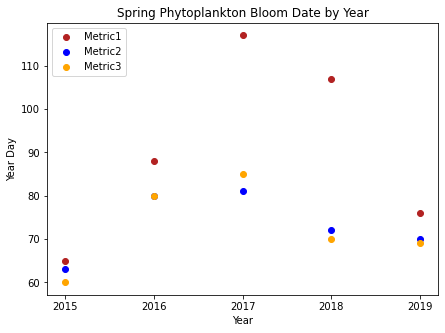

In [35]:
# plot bloomtime for each year: 
fig,ax=plt.subplots(1,1,figsize=(7,5))
p1=ax.plot(years,yearday1, 'o',color='firebrick',label='Metric1')
p2=ax.plot(years,yearday2, 'o',color='b',label='Metric2')
p3=ax.plot(years,yearday3, 'o',color='orange',label='Metric3')
ax.set_ylabel('Year Day')
ax.set_xlabel('Year')
ax.set_title('Spring Phytoplankton Bloom Date by Year')
ax.set_xticks([2015,2016,2017,2018,2019])
ax.legend(handles=[p1[0],p2[0],p3[0]],loc='upper left')

### Monthly average wind speed cubed (January-March)

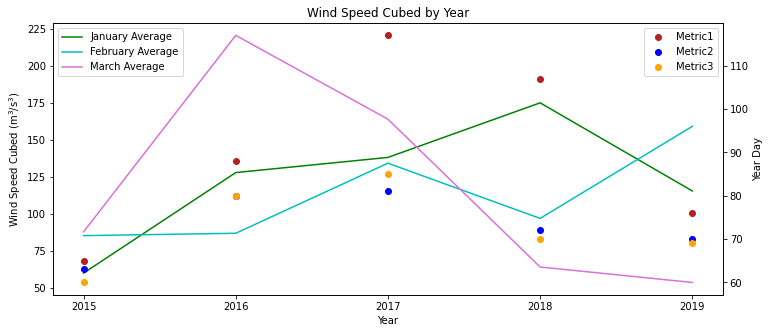

In [36]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,windjan, '-',color='green',label='January Average')
p2=ax.plot(years,windfeb, '-',color='c',label='February Average')
p3=ax.plot(years,windmar, '-',color='orchid',label='March Average')
ax.set_ylabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax.set_xlabel('Year')
ax.set_title('Wind Speed Cubed by Year')
ax.set_xticks([2015,2016,2017,2018,2019])
ax.legend(handles=[p1[0],p2[0],p3[0]],loc='upper left')

ax1=ax.twinx()
p4=ax1.plot(years,yearday1, 'o',color='firebrick',label='Metric1')
p5=ax1.plot(years,yearday2, 'o',color='b',label='Metric2')
p6=ax1.plot(years,yearday3, 'o',color='orange',label='Metric3')
ax1.set_ylabel('Year Day')
ax1.legend(handles=[p4[0],p5[0],p6[0]],loc='upper right')

### Monthly average solar radiation (January-March)

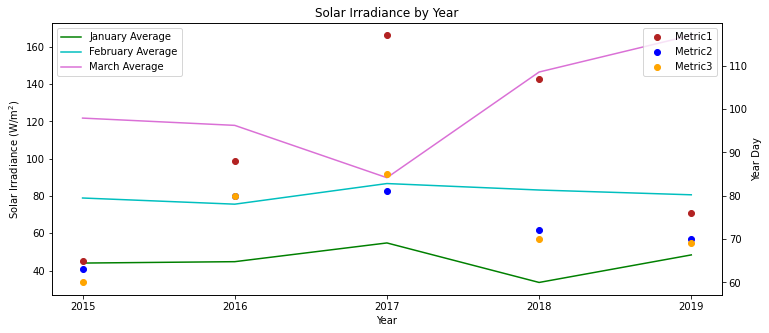

In [37]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,solarjan, '-',color='green',label='January Average')
p2=ax.plot(years,solarfeb, '-',color='c',label='February Average')
p3=ax.plot(years,solarmar, '-',color='orchid',label='March Average')
ax.set_ylabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax.set_xlabel('Year')
ax.set_title('Solar Irradiance by Year')
ax.set_xticks([2015,2016,2017,2018,2019])
ax.legend(handles=[p1[0],p2[0],p3[0]],loc='upper left')

ax1=ax.twinx()
p4=ax1.plot(years,yearday1, 'o',color='firebrick',label='Metric1')
p5=ax1.plot(years,yearday2, 'o',color='b',label='Metric2')
p6=ax1.plot(years,yearday3, 'o',color='orange',label='Metric3')
ax1.set_ylabel('Year Day')
ax1.legend(handles=[p4[0],p5[0],p6[0]],loc='upper right')

### Monthly average photosynthetically available radiation (PAR) (January-March)

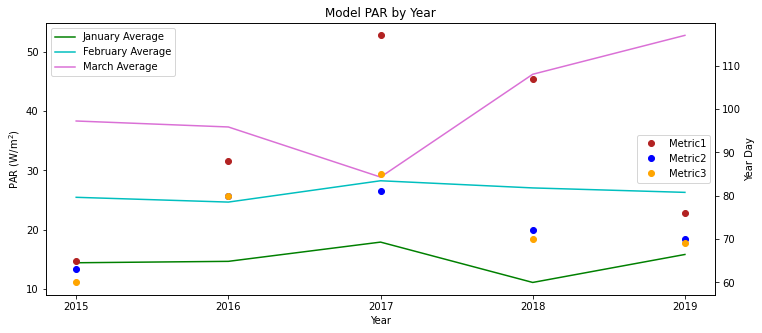

In [38]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,parjan, '-',color='green',label='January Average')
p2=ax.plot(years,parfeb, '-',color='c',label='February Average')
p3=ax.plot(years,parmar, '-',color='orchid',label='March Average')
ax.set_ylabel('PAR (W/$\mathregular{m^2}$)')
ax.set_xlabel('Year')
ax.set_title('Model PAR by Year')
ax.set_xticks([2015,2016,2017,2018,2019])
ax.legend(handles=[p1[0],p2[0],p3[0]],loc='upper left')

ax1=ax.twinx()
p4=ax1.plot(years,yearday1, 'o',color='firebrick',label='Metric1')
p5=ax1.plot(years,yearday2, 'o',color='b',label='Metric2')
p6=ax1.plot(years,yearday3, 'o',color='orange',label='Metric3')
ax1.set_ylabel('Year Day')
ax1.legend(handles=[p4[0],p5[0],p6[0]],loc='center right')

### Monthly average surface temperature (January-March)

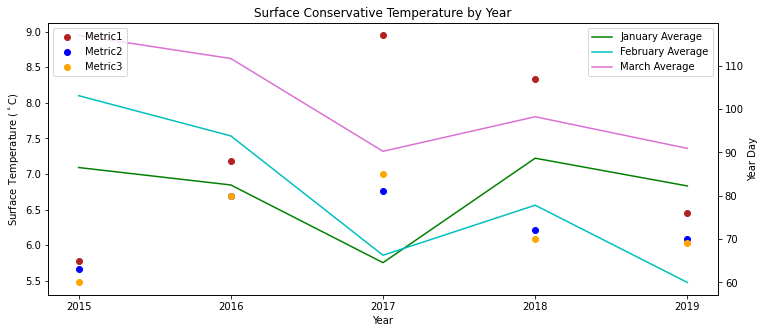

In [39]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,tempjan, '-',color='green',label='January Average')
p2=ax.plot(years,tempfeb, '-',color='c',label='February Average')
p3=ax.plot(years,tempmar, '-',color='orchid',label='March Average')
ax.set_ylabel('Surface Temperature ($^\circ$C)')
ax.set_xlabel('Year')
ax.set_title('Surface Conservative Temperature by Year')
ax.set_xticks([2015,2016,2017,2018,2019])
ax.legend(handles=[p1[0],p2[0],p3[0]],loc='upper right')

ax1=ax.twinx()
p4=ax1.plot(years,yearday1, 'o',color='firebrick',label='Metric1')
p5=ax1.plot(years,yearday2, 'o',color='b',label='Metric2')
p6=ax1.plot(years,yearday3, 'o',color='orange',label='Metric3')
ax1.set_ylabel('Year Day')
ax1.legend(handles=[p4[0],p5[0],p6[0]],loc='upper left')

### Monthly average surface salinity (January-March)

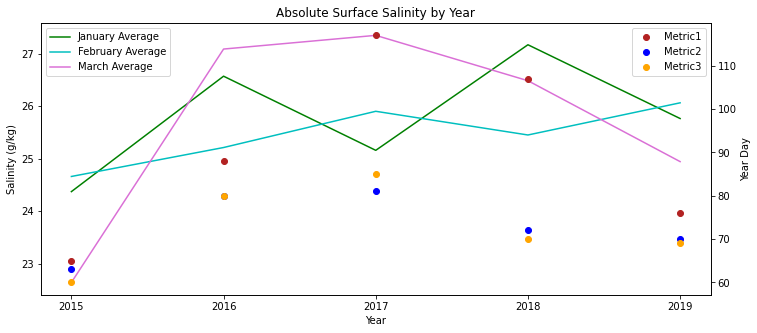

In [40]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,saljan, '-',color='green',label='January Average')
p2=ax.plot(years,salfeb, '-',color='c',label='February Average')
p3=ax.plot(years,salmar, '-',color='orchid',label='March Average')
ax.set_ylabel('Salinity (g/kg)')
ax.set_xlabel('Year')
ax.set_title('Absolute Surface Salinity by Year')
ax.set_xticks([2015,2016,2017,2018,2019])
ax.legend(handles=[p1[0],p2[0],p3[0]],loc='upper left')

ax1=ax.twinx()
p4=ax1.plot(years,yearday1, 'o',color='firebrick',label='Metric1')
p5=ax1.plot(years,yearday2, 'o',color='b',label='Metric2')
p6=ax1.plot(years,yearday3, 'o',color='orange',label='Metric3')
ax1.set_ylabel('Year Day')
ax1.legend(handles=[p4[0],p5[0],p6[0]],loc='upper right')

### Monthly average Fraser river flow (January-March)

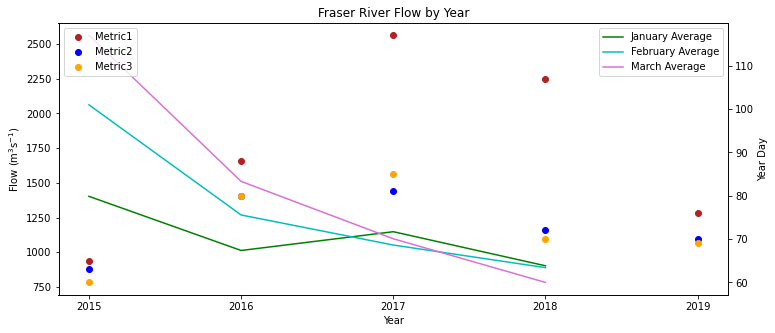

In [10]:
yearnot19=years[0:4]
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(yearnot19,fraserjan, '-',color='green',label='January Average')
p2=ax.plot(yearnot19,fraserfeb, '-',color='c',label='February Average')
p3=ax.plot(yearnot19,frasermar, '-',color='orchid',label='March Average')
ax.set_ylabel('Flow (m$^3$s$^{-1}$)')
ax.set_xlabel('Year')
ax.set_title('Fraser River Flow by Year')
ax.set_xticks([2015,2016,2017,2018,2019])
ax.legend(handles=[p1[0],p2[0],p3[0]],loc='upper right')

ax1=ax.twinx()
p4=ax1.plot(years,yearday1, 'o',color='firebrick',label='Metric1')
p5=ax1.plot(years,yearday2, 'o',color='b',label='Metric2')
p6=ax1.plot(years,yearday3, 'o',color='orange',label='Metric3')
ax1.set_ylabel('Year Day')
ax1.legend(handles=[p4[0],p5[0],p6[0]],loc='upper left')

### Monthly average surface zooplankton concentration (January-March)

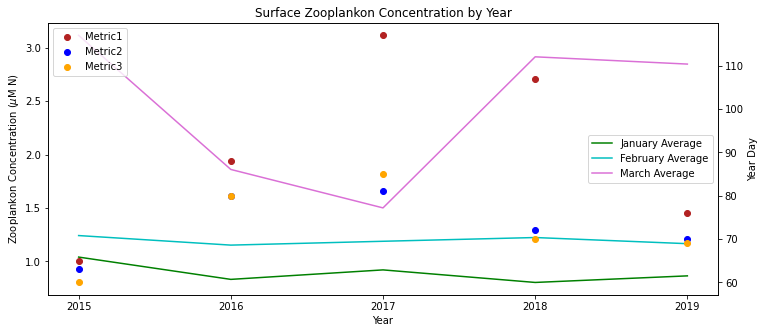

In [11]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,zoojan, '-',color='green',label='January Average')
p2=ax.plot(years,zoofeb, '-',color='c',label='February Average')
p3=ax.plot(years,zoomar, '-',color='orchid',label='March Average')
ax.set_ylabel('Zooplankon Concentration ($\mu$M N)')
ax.set_xlabel('Year')
ax.set_title('Surface Zooplankon Concentration by Year')
ax.set_xticks([2015,2016,2017,2018,2019])
ax.legend(handles=[p1[0],p2[0],p3[0]],loc='center right')

ax1=ax.twinx()
p4=ax1.plot(years,yearday1, 'o',color='firebrick',label='Metric1')
p5=ax1.plot(years,yearday2, 'o',color='b',label='Metric2')
p6=ax1.plot(years,yearday3, 'o',color='orange',label='Metric3')
ax1.set_ylabel('Year Day')
ax1.legend(handles=[p4[0],p5[0],p6[0]],loc='upper left')

### Nitrate

mid-depth nitrate, say 30-90m (try for each location)

January nitrate concentration in deep SoG (below 250 m)